In [1]:
import pandas as pd
import numpy as np

In [2]:
df_csv_bio = pd.read_csv('data/sequences_bio_clean_alignment_filtro.csv', sep=',')


### Vectorización por ESM

In [3]:
from transformers import AutoTokenizer, EsmModel
import torch

model_name = "facebook/esm2_t33_650M_UR50D"  # o cualquier otro ESM-2 que prefieras
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = EsmModel.from_pretrained(model_name)

#sequences = df_csv_bio['alignment'].to_list()

#Para usar la secuencia original, descomentar la siguiente línea y comentar la anterior
sequences = df_csv_bio['sequence_20'].to_list()
inputs = tokenizer(sequences, return_tensors="pt", padding=True)

with torch.no_grad():
     outputs = model(**inputs)

embeddings = outputs.last_hidden_state  # forma: [batch_size, seq_len, hidden_dim]
print(embeddings.shape)

seq_embeddings = embeddings[:, 1:-1, :].mean(dim=1).numpy()  # [n_seq, hidden_dim]


/Users/pablo1n7/miniconda3/envs/tab/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


torch.Size([1334, 22, 1280])


In [4]:
from sklearn.decomposition import PCA
import plotly.express as px

### Visualización usando PCA

In [5]:
pca = PCA(n_components=4)
embedding_pca = pca.fit_transform(seq_embeddings)

fig = px.scatter(
    x=embedding_pca[:, 0],
    y=embedding_pca[:, 1],
    color=df_csv_bio['Species Family'].to_list(),
    title="PCA de embeddings agrupación bioquímica de proteínas por especie",
    labels={"x": "PCA1", "y": "PCA2"},
    hover_data=[df_csv_bio['Peptide_Family']]
)

fig.update_traces(marker=dict(size=12, line=dict(width=1, color="DarkSlateGrey")))
fig.show()

In [6]:
fig = px.scatter(
    x=embedding_pca[:, 0],
    y=embedding_pca[:, 1],
    color=df_csv_bio['Peptide_Family'].to_list(),
    title="PCA de embeddings agrupación bioquímica de proteínas por familia de péptidos",
    labels={"x": "PCA0", "y": "PCA1"}
)

fig.update_traces(marker=dict(size=12, line=dict(width=1, color="DarkSlateGrey")))
fig.show()

In [7]:

df_plot = pd.DataFrame({
    "PC1": embedding_pca[:, 0],
    "PC2": embedding_pca[:, 1],
    "PC3": embedding_pca[:, 2],
    "Peptide_Family": df_csv_bio['Peptide_Family'].to_list(),
    "Family": df_csv_bio['Species Family'].to_list(),
    "seq_id": df_csv_bio.get('seq_id', [f"Seq{i+1}" for i in range(len(embedding_pca))]),
    "sequence_20": df_csv_bio.get('sequence_20', None)
})

fig = px.scatter_3d(
    df_plot,
    x="PC1",
    y="PC2",
    z="PC3",
    color="Peptide_Family",
    hover_name="seq_id",
    hover_data={"sequence_20": True, "Family": True, "PC1": False, "PC2": False, "PC3": False},
    title="PCA 3D de embeddings agrupación bioquímica de proteínas por familia de péptidos",
    labels={"PC1": "PCA0", "PC2": "PCA1", "PC3": "PCA2"},
)

fig.update_traces(marker=dict(size=6, line=dict(width=0.5)), selector=dict(mode='markers'))
fig.show()




In [8]:
from scipy.spatial.distance import pdist, squareform
from skbio import DistanceMatrix
from skbio.stats.distance import permanova


### PERMANOVA entre todos los grupos de péptidos

In [9]:
groups = np.array(df_csv_bio['Peptide_Family'].to_list())

X = np.array(seq_embeddings)

dists = squareform(pdist(X, metric='euclidean'))

dm = DistanceMatrix(dists, ids=[f"s{i}" for i in range(len(seq_embeddings))])
metadata = pd.DataFrame({"group": groups}, index=dm.ids)

res_perm = permanova(dm, metadata, column='group', permutations=999)
print(res_perm)

method name               PERMANOVA
test statistic name        pseudo-F
sample size                    1334
number of groups                 12
test statistic             20.81591
p-value                       0.001
number of permutations          999
Name: PERMANOVA results, dtype: object


In [10]:
import itertools

### PERMANOVA entre pares de familia de péptidos

In [11]:
unique_groups = np.unique(groups)

pairwise_results = []

for g1, g2 in itertools.combinations(unique_groups, 2):
    idx = metadata['group'].isin([g1, g2])
    
    sub_dm = dm.filter(metadata.index[idx])
    sub_meta = metadata.loc[idx]
    
    res = permanova(sub_dm, sub_meta, column='group', permutations=999)
    
    pairwise_results.append({
        'group1': g1,
        'group2': g2,
        'pseudo-F': res['test statistic'],
        'p-value': res['p-value']
    })

pairwise_df = pd.DataFrame(pairwise_results)
print(pairwise_df)

          group1       group2   pseudo-F  p-value
0       Amolopin     Brevinin   4.878643    0.008
1       Amolopin  Dermaseptin  47.363031    0.001
2       Amolopin   Esculentin  11.737845    0.001
3       Amolopin     Gaegurin  20.634235    0.001
4       Amolopin     Nigrocin   1.203189    0.271
..           ...          ...        ...      ...
61  Phylloseptin      Rugosin  94.933228    0.001
62  Phylloseptin     Temporin  31.053808    0.001
63    Ranatuerin      Rugosin  16.868854    0.001
64    Ranatuerin     Temporin  10.662122    0.001
65       Rugosin     Temporin  43.139470    0.001

[66 rows x 4 columns]


In [12]:
from statsmodels.stats.multitest import multipletests
import seaborn as sns
import matplotlib.pyplot as plt

### Ajustar *p_values* con FDR (Benjamini-Hochberg)

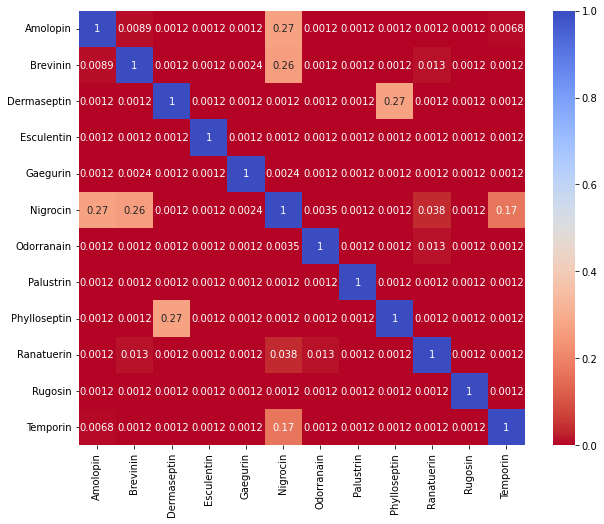

In [13]:

reject, pvals_corrected, _, _ = multipletests(pairwise_df['p-value'], method='fdr_bh')
pairwise_df['p-value_adj'] = pvals_corrected
pairwise_df['significant'] = reject

pval_matrix = pd.DataFrame(np.ones((len(unique_groups), len(unique_groups))),
                           index=unique_groups, columns=unique_groups)

for _, row in pairwise_df.iterrows():
    pval_matrix.loc[row['group1'], row['group2']] = row['p-value_adj']
    pval_matrix.loc[row['group2'], row['group1']] = row['p-value_adj']

plt.figure(figsize=(10,8))
sns.heatmap(pval_matrix, annot=True, cmap='coolwarm_r', vmin=0, vmax=1)

#plt.savefig('fig/permanova/ESM_alineacion_permanova_heatmap.png')

#descomentar la siguiente línea para guardar el heatmap de la secuencia
plt.savefig('fig/permanova/ESM_secuencia_permanova_heatmap.png')

In [14]:
import matplotlib.ticker as mticker


<Figure size 648x504 with 0 Axes>

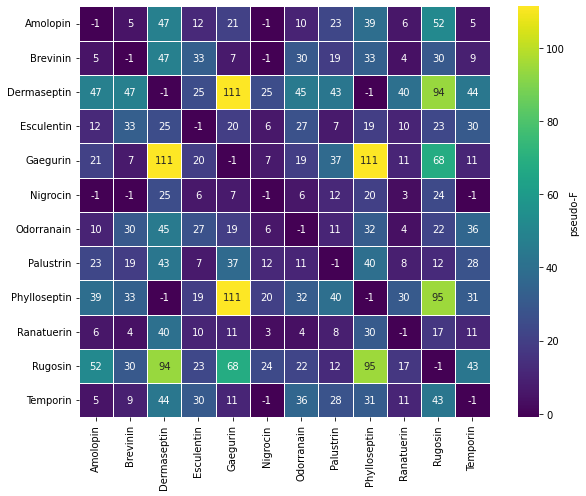

In [15]:
# --- Heatmap de p-values (mantengo decimales) ---
plt.figure(figsize=(9,7))

pseudoF_matrix = pd.DataFrame(np.zeros((len(unique_groups), len(unique_groups))) -1 ,
                              index=unique_groups, columns=unique_groups)


for _, row in pairwise_df.iterrows():
    if row['significant']:
        pseudoF_matrix.loc[row['group1'], row['group2']] = row['pseudo-F']
        pseudoF_matrix.loc[row['group2'], row['group1']] = row['pseudo-F']

pseudoF_int = np.rint(pseudoF_matrix.values).astype(int)    # redondea y convierte a int
annot = pseudoF_int.astype(str)                             # matriz de strings para anotación

plt.figure(figsize=(9,7))
ax2 = sns.heatmap(pseudoF_matrix, annot=annot, fmt='', cmap='viridis',
                  linewidths=.5, linecolor='white',
                  square=True, cbar_kws={'label':'pseudo-F'}
                 )

# 2) forzar formato entero en la barra de color (evita notación científica)
ax2.collections[0].colorbar.ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%d'))

#plt.savefig('fig/permanova/ESM_alineacion_permanova_heatmap_pseudo-f.png')

#descomentar la siguiente línea para guardar el heatmap de la secuencia
plt.savefig('fig/permanova/ESM_secuencia_permanova_heatmap_pseudo-f.png')

plt.tight_layout()
plt.show()